In [25]:
import torch
import numpy as np
import pandas as pd
from PIL import Image
import codecs
import matplotlib.pyplot as plt
import math

In [26]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hojjatk/mnist-dataset")

print("Path to dataset files:", path)

# copy the downloaded dataset to the current directory
import shutil
shutil.copytree(path, "dataset", dirs_exist_ok=True)


Path to dataset files: /home/ahmedayman4a/.cache/kagglehub/datasets/hojjatk/mnist-dataset/versions/1


'dataset'

In [27]:
def get_int(b):
    return int(codecs.encode(b, 'hex'), 16)

def read_label_file(path):
    with open(path, 'rb') as f:
        data = f.read()
        assert get_int(data[:4]) == 2049
        length = get_int(data[4:8])
        parsed = np.frombuffer(data, dtype=np.uint8, offset=8)
        return np.array(parsed, dtype=np.uint8).reshape(length)


def read_image_file(path):
    with open(path, 'rb') as f:
        data = f.read()
        assert get_int(data[:4]) == 2051
        length = get_int(data[4:8])
        num_rows = get_int(data[8:12])
        num_cols = get_int(data[12:16])
        parsed = np.frombuffer(data, dtype=np.uint8, offset=16)
        return np.array(parsed, dtype=np.uint8).reshape((length,num_rows,num_cols))

In [28]:
train_images = read_image_file('dataset/train-images.idx3-ubyte')
train_labels = read_label_file('dataset/train-labels.idx1-ubyte')
test_images = read_image_file('dataset/t10k-images.idx3-ubyte')
test_labels = read_label_file('dataset/t10k-labels.idx1-ubyte')

print(train_images.shape, train_labels.shape)

(60000, 28, 28) (60000,)


In [29]:
# concat train and test
images = np.concatenate([train_images, test_images])
labels = np.concatenate([train_labels, test_labels])

In [30]:
from sklearn.model_selection import train_test_split
train_test_images, val_images, train_test_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)
train_images, test_images, train_labels, test_labels = train_test_split(train_test_images, train_test_labels, test_size=0.2, random_state=42)

In [31]:
print(train_images.shape, train_labels.shape)

(44800, 28, 28) (44800,)


In [32]:
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor, Normalize

In [33]:
class MNISTDataset(Dataset):
    def __init__(self, images, labels, image_transform:Compose = None):
        self.images = images
        self.labels = labels
        self.image_transform = image_transform

    def __getitem__(self, index: int):
        image, label = self.images[index], self.labels[index]
        image = Image.fromarray(image, mode='L')
        if self.image_transform is not None:
            image = self.image_transform(image)
            
        return image, label
        
    def __len__(self):
        return len(self.images)

In [34]:
image_transform = Compose([
    ToTensor(),
    Normalize((0.1307,), (0.3081,))
])

In [35]:
train_dataset = MNISTDataset(train_images, train_labels, image_transform)
val_dataset = MNISTDataset(val_images, val_labels, image_transform)
test_dataset = MNISTDataset(test_images, test_labels, image_transform)

In [36]:
train_loader = DataLoader(train_dataset, batch_size=64, num_workers=8, prefetch_factor=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, num_workers=8, prefetch_factor=8)
test_loader = DataLoader(test_dataset, batch_size=64, num_workers=8, prefetch_factor=8)

In [37]:
def visualize_batch(loader):
    batch_images, batch_labels = next(iter(loader))
    print(batch_images.size(), batch_labels.size())
    batch_size = batch_images.size(0)
    cols = math.ceil(math.sqrt(batch_size))
    rows = math.ceil(batch_size / cols)
    # Create a grid of images
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    for i, (image, label) in enumerate(zip(batch_images, batch_labels)):
        ax = axes[i//rows, i%cols]
        # Convert tensor back to image for display
        ax.imshow(image.squeeze(), cmap='gray')
        ax.axis('off')
        ax.set_title(f'Label: {label.item()}')
    plt.tight_layout()
    plt.show()

torch.Size([64, 1, 28, 28]) torch.Size([64])


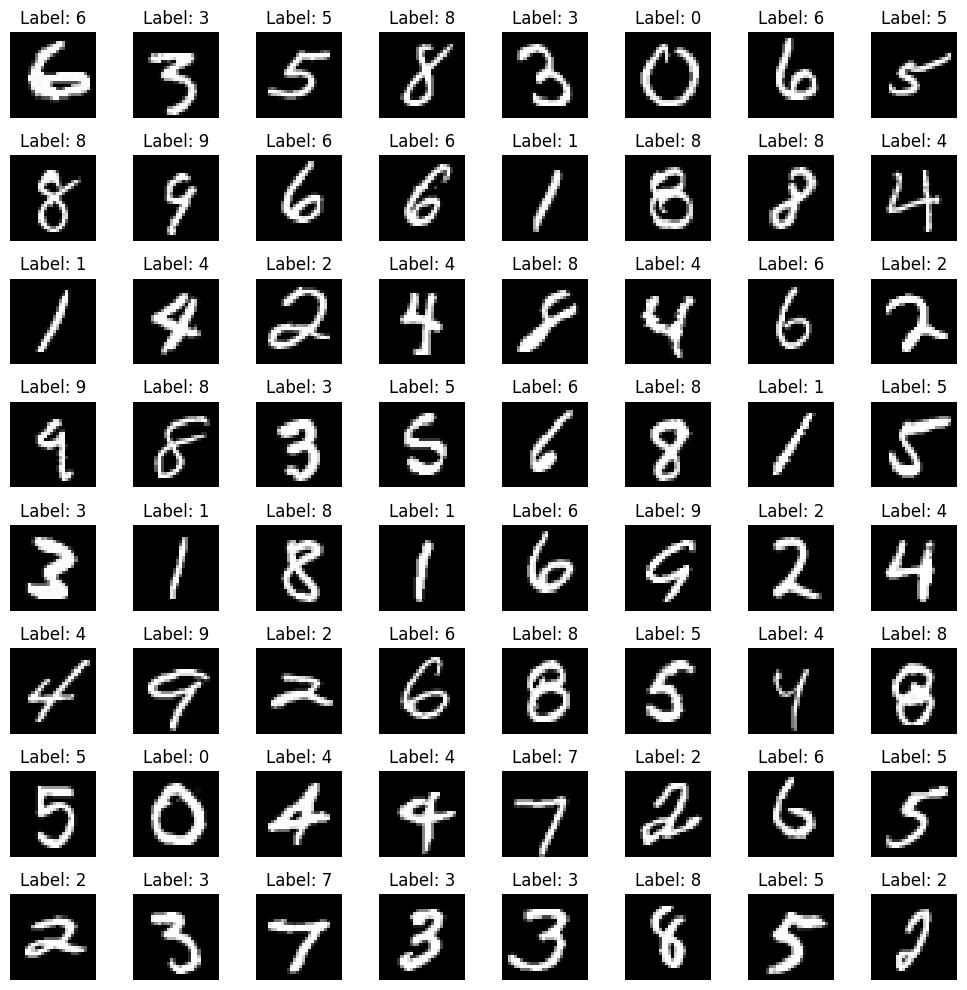

In [38]:
visualize_batch(test_loader)

# Softmax Regression Model

In [39]:
from dataclasses import dataclass
from typing import Optional
import torch

@dataclass
class TrainingConfig:
    # Model parameters
    input_size: int = 28 * 28
    output_size: int = 10
    
    # Training parameters
    batch_size: int = 64
    num_epochs: int = 10
    learning_rate: float = 0.01
    weight_decay: float = 0.0
    
    # LR scheduler parameters
    scheduler_type: str = "none"  # "none", "cosine", "warmup_cosine"
    warmup_epochs: int = 0
    min_lr: float = 1e-5
    
    # Regularization
    dropout_rate: float = 0.0
    
    # DataLoader parameters
    num_workers: int = 8
    prefetch_factor: int = 8
    
    # Device
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Experiment name
    experiment_name: str = "mnist_softmax"
    
    project_name: str = "mnist-softmax-2"

In [40]:
class SoftmaxRegression(torch.nn.Module):
    def __init__(self, input_size, output_size, dropout_rate=0.0):
        super(SoftmaxRegression, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.dropout = torch.nn.Dropout(dropout_rate)
        self.linear = torch.nn.Linear(input_size, output_size)

    def forward(self, x):
        x = x.view(-1, self.input_size) # remove the channel dimension, flatten the image
        x = self.dropout(x)
        return self.linear(x)

In [41]:
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR
from tqdm import tqdm
from tabulate import tabulate
import wandb

In [42]:
wandb.login(key="d8ff0fac98c036a4ac0587814c4fd1a2e60f2512")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/ahmedayman4a/.netrc


True

In [65]:
import wandb
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

class WandBLogger:
    def __init__(self, config):
        self.run = wandb.init(
            project=config.project_name,
            name=config.experiment_name,
            config=config.__dict__
        )
        
    def log_model_graph(self, model, loss):
        wandb.watch(model, criterion=loss, log="all", log_freq=100)
        
    def log_batch_predictions(self, images, labels, predictions, step):
        # Log sample predictions
        fig, ax = plt.subplots(4, 4, figsize=(10, 10))
        for idx in range(16):
            i, j = idx//4, idx%4
            ax[i,j].imshow(images[idx].squeeze(), cmap='gray')
            ax[i,j].set_title(f'Pred: {predictions[idx]}\nTrue: {labels[idx]}')
            ax[i,j].axis('off')
        wandb.log({"predictions": wandb.Image(fig)}, commit=False)
        plt.close()
        
    def log_confusion_matrix(self, true_labels, predictions, step):
        cm = confusion_matrix(true_labels, predictions)
        fig = plt.figure(figsize=(10, 10))
        sns.heatmap(cm, annot=True, fmt='d')
        wandb.log({"confusion_matrix": wandb.Image(fig)}, commit=False)
        plt.close()
        
    def log_grad_flow(self, named_parameters):
        ave_grads = []
        layers = []
        for n, p in named_parameters:
            if p.requires_grad and p.grad is not None:
                layers.append(n)
                ave_grads.append(p.grad.abs().mean().item())
        fig = plt.figure(figsize=(10, 5))
        plt.plot(ave_grads, alpha=0.3, color="b")
        plt.title("Gradient Flow")
        wandb.log({"grad_flow": wandb.Image(fig)}, commit=False)
        plt.close()
        
    def log_misclassified(self, images, labels, predictions, step):
        mask = predictions != labels
        if not mask.any():
            return
            
        misclassified_images = images[mask][:16]
        misclassified_labels = labels[mask][:16]
        misclassified_preds = predictions[mask][:16]
        
        fig, ax = plt.subplots(4, 4, figsize=(10, 10))
        for idx in range(min(16, len(misclassified_images))):
            i, j = idx//4, idx%4
            ax[i,j].imshow(misclassified_images[idx].squeeze(), cmap='gray')
            ax[i,j].set_title(f'Pred: {misclassified_preds[idx]}\nTrue: {misclassified_labels[idx]}')
            ax[i,j].axis('off')
        wandb.log({"misclassified": wandb.Image(fig)}, commit=False)
        plt.close()

In [66]:
class TrainingManager:
    def __init__(self, config: TrainingConfig):
        self.config = config
        self.logger = WandBLogger(config)
        
    def get_scheduler(self, optimizer):
        if self.config.scheduler_type == "none":
            return None
        elif self.config.scheduler_type == "cosine":
            return torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer, 
                T_max=self.config.num_epochs, 
                eta_min=self.config.min_lr
            )
        elif self.config.scheduler_type == "warmup_cosine":
            warmup_scheduler = LinearLR(optimizer, total_iters=self.config.warmup_epochs)
            main_scheduler = CosineAnnealingLR(optimizer, T_max=self.config.num_epochs - self.config.warmup_epochs, eta_min=self.config.min_lr)
            scheduler = SequentialLR(optimizer, schedulers=[warmup_scheduler, main_scheduler], milestones=[self.config.warmup_epochs])
            return scheduler
    
    def train(self, model, train_loader, val_loader):
        model = model.to(self.config.device)
        optimizer = torch.optim.SGD(
            model.parameters(), 
            lr=self.config.learning_rate,
            weight_decay=self.config.weight_decay
        )
        scheduler = self.get_scheduler(optimizer)
        criterion = torch.nn.CrossEntropyLoss()
        self.logger.log_model_graph(model, criterion)
        
        for epoch in range(self.config.num_epochs):
            # Training
            model.train()
            train_loss = 0
            correct = 0
            total = 0
            
            for batch_idx, (inputs, targets) in enumerate(train_loader):
                inputs, targets = inputs.to(self.config.device), targets.to(self.config.device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
                
            train_acc = 100. * correct / total
            train_loss = train_loss / len(train_loader)
            
            # Validation
            val_loss, val_acc = self.validate(model, val_loader, criterion, epoch)
            
            # Update scheduler
            if scheduler is not None:
                scheduler.step()
                
            # Log metrics
            wandb.log({
                "epoch": epoch,
                "train_loss": train_loss,
                "train_acc": train_acc,
                "val_loss": val_loss,
                "val_acc": val_acc,
                "learning_rate": optimizer.param_groups[0]['lr'],
                "parameter_histograms": wandb.Histogram(
                    torch.cat([p.data.cpu().flatten() for p in model.parameters()])
                )
            })
            
        wandb.finish()
        
    def validate(self, model, val_loader, criterion, epoch):
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        val_images, val_labels = [], []
        val_preds = []
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(self.config.device), targets.to(self.config.device)
                preds = model(inputs)
                loss = criterion(preds, targets)
                
                val_loss += loss.item()
                _, predicted = preds.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
                predictions = preds.argmax(dim=1)
                val_images.extend(inputs.cpu())
                val_labels.extend(targets.cpu())
                val_preds.extend(predictions.cpu())
                
        val_images = torch.stack(val_images)
        val_labels = torch.tensor(val_labels)
        val_preds = torch.tensor(val_preds)
        
        # Log validation artifacts
        self.logger.log_batch_predictions(
            val_images[:16], 
            val_labels[:16], 
            val_preds[:16], 
            epoch
        )
        self.logger.log_confusion_matrix(
            val_labels, 
            val_preds, 
            epoch
        )
        self.logger.log_misclassified(
            val_images,
            val_labels, 
            val_preds,
            epoch
        )
        self.logger.log_grad_flow(model.named_parameters())
            
        return val_loss / len(val_loader), 100. * correct / total

In [67]:
experiments = [
    TrainingConfig(learning_rate=1.0, experiment_name="lr_1.0"),
    TrainingConfig(learning_rate=0.01, experiment_name="lr_0.01"),
    TrainingConfig(learning_rate=0.00001, experiment_name="lr_0.00001"),
    TrainingConfig(
        learning_rate=0.01, 
        scheduler_type="warmup_cosine",
        warmup_epochs=5,
        experiment_name="warmup_cosine"
    ),
    TrainingConfig(batch_size=1, experiment_name="batch_1"),
    TrainingConfig(batch_size=16, experiment_name="batch_16"),
    TrainingConfig(batch_size=256, experiment_name="batch_256"),
    TrainingConfig(
        learning_rate=0.01,
        weight_decay=0.01,
        dropout_rate=0.2,
        experiment_name="with_regularization"
    ),
]

In [68]:
def run_experiments():
    for config in experiments:
        print(f"Running experiment: {config.experiment_name}")
        
        # Create data loaders
        train_loader = DataLoader(
            train_dataset, 
            batch_size=config.batch_size,
            num_workers=config.num_workers,
            prefetch_factor=config.prefetch_factor,
            shuffle=True
        )
        val_loader = DataLoader(
            val_dataset,
            batch_size=config.batch_size,
            num_workers=config.num_workers,
            prefetch_factor=config.prefetch_factor
        )
        
        # Create model and trainer
        model = SoftmaxRegression(config.input_size, config.output_size, config.dropout_rate)
        trainer = TrainingManager(config)
        
        # Train model
        trainer.train(model, train_loader, val_loader)


In [69]:
run_experiments()

Running experiment: lr_1.0


epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,▁▁▁▁▁▁▁▁▁█
train_acc,▁▆▆▇▇████▄
train_loss,▂▁▁▁▁▁▁▁▁█
val_acc,▄▆▆▇▇████▁
val_loss,▁▁▁▁▁▁▁▁▁█
epoch,9
learning_rate,1
train_acc,89.07812
train_loss,1.48446
val_acc,88.62143


Running experiment: lr_0.01


epoch,▁
learning_rate,▁
train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
epoch,9
learning_rate,0.01
train_acc,92.18304
train_loss,0.27505
val_acc,91.81429


Running experiment: lr_0.00001


epoch,▁
learning_rate,▁
train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
epoch,9
learning_rate,1e-05
train_acc,58.83705
train_loss,1.65743
val_acc,60.40714


Running experiment: warmup_cosine


KeyboardInterrupt: 